# 📕 02 - Object Detection with YOLOv8 (ou YOLOv9) and Supervision

In [2]:
# Importing necessary libraries
import numpy as np
import supervision as sv
from ultralytics import YOLO

from src.path import DATA_PATH, MODELS_PATH

# Setting the source
SOURCE = np.array([[642, 784], [1960, 881], [1146, 1009], [-161, 852]])

# Setting the video path
video_path = str(DATA_PATH / "santos_dumont_airport.mp4")

# Setting matplotlib to best resolution when plotting
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


0: 384x640 3 airplanes, 1239.6ms
Speed: 7.7ms preprocess, 1239.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)


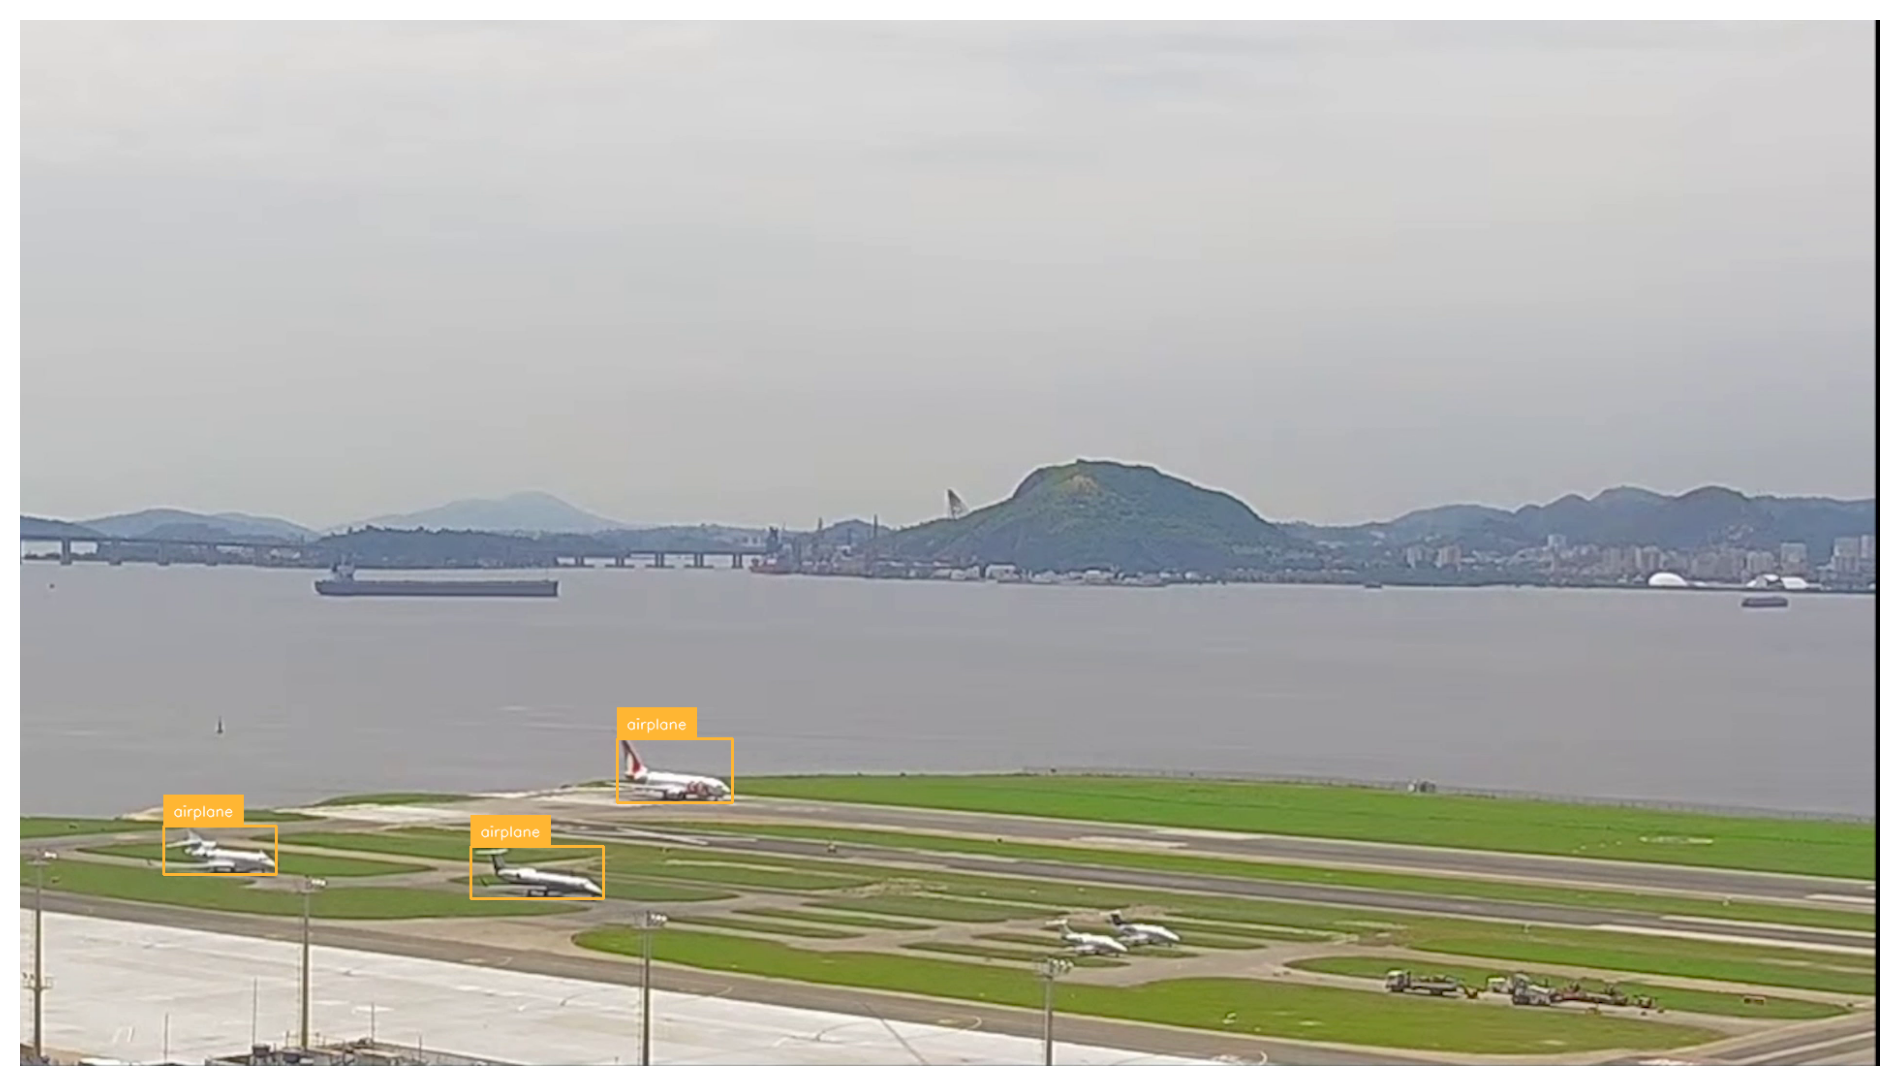

In [3]:
# Create a frame generator
frame_generator = sv.get_video_frames_generator(source_path=video_path)

# Get the first frame
frame = next(frame_generator)

# Define the model path
model_weights = MODELS_PATH / "yolov8x.pt"

# Load the YOLO model
model = YOLO(model_weights)

# Get the results from the model
results = model(frame)[0]

# Create detections from the results
detections = sv.Detections.from_ultralytics(results)

# Create annotators
bounding_box_annotator = sv.BoundingBoxAnnotator()
label_annotator = sv.LabelAnnotator()

# Annotate the frame
annotated_frame = frame.copy()
annotated_frame = label_annotator.annotate(annotated_frame, detections)
annotated_frame = bounding_box_annotator.annotate(annotated_frame, detections)

# Plot the annotated frame
sv.plot_image(annotated_frame)


0: 384x640 5 airplanes, 2521.8ms
Speed: 77.2ms preprocess, 2521.8ms inference, 3.2ms postprocess per image at shape (1, 3, 384, 640)


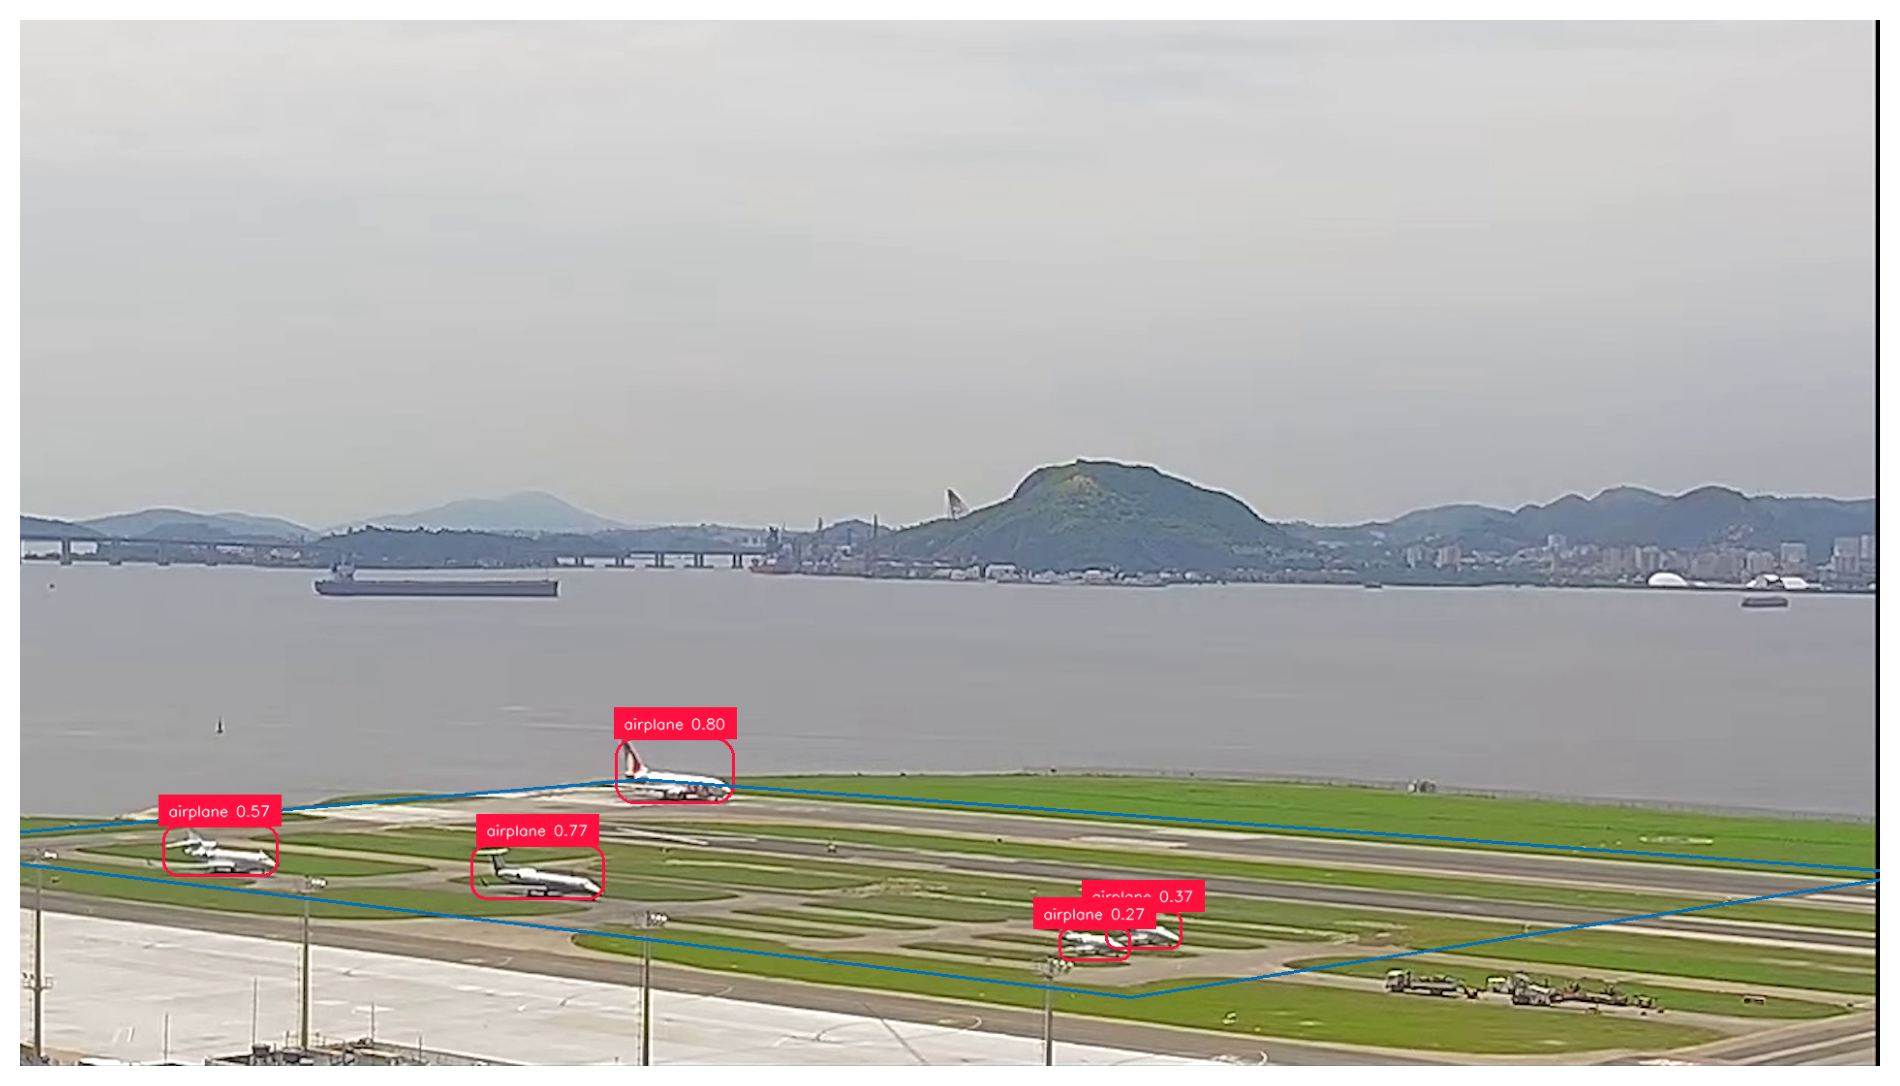

In [7]:
# Initialize colors
color_sigmoidal = sv.Color.from_hex("#ff103f")
color_polygon = sv.Color.from_hex("#016FB9")

# Setup video information and polygon zone
video_info = sv.VideoInfo.from_video_path(video_path)
frame_resolution_wh = video_info.resolution_wh
polygon_zone = sv.PolygonZone(SOURCE, frame_resolution_wh)

# Initialize annotators
round_box_annotator = sv.RoundBoxAnnotator(color_sigmoidal)
label_annotator = sv.LabelAnnotator(
    color=color_sigmoidal, text_position=sv.Position.TOP_CENTER
)
polygon_zone_annotator = sv.PolygonZoneAnnotator(
    polygon_zone, color=color_polygon, thickness=2, display_in_zone_count=False
)

# Process frame and detections
frame = next(frame_generator)
results = model(frame)[0]
detections = sv.Detections.from_ultralytics(results)

# Filter the detections
detections = detections[detections.confidence > 0.1]
detections = detections[detections.class_id == 4]
detections = detections[polygon_zone.trigger(detections)]

labels = [
    f"{results.names[class_id]} {confidence:.2f}"
    for _, _, confidence, class_id, _, _ in detections
]

# Annotate and display the frame
annotated_frame = frame.copy()
annotated_frame = round_box_annotator.annotate(annotated_frame, detections)
annotated_frame = polygon_zone_annotator.annotate(annotated_frame)
annotated_frame = label_annotator.annotate(annotated_frame, detections, labels)
sv.plot_image(annotated_frame)